# Trainig Model for Diabetes Prediction

- Data Cleaing
- Feature Selection
- Feature Engineering
- One Hot Encoding

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [3]:
df = pd.read_csv("../data/diabetes_prediction_dataset.csv")
print('Number of Duplicate rows: ', df.duplicated().sum())
df['smoking_history'] = df['smoking_history'].replace({'never':'non_smoker',
                                                       'No Info': 'non_smoker',
                                                       'former': 'past_smoker',
                                                       'current': 'current_smoker',
                                                       'not current': 'past_smoker',
                                                       'ever' : 'past_smoker'})

print('Number of Duplicate rows: ', df.duplicated().sum())


Number of Duplicate rows:  3854
Number of Duplicate rows:  6011


In [4]:
df.drop_duplicates(inplace=True)

In [5]:
df.duplicated().sum()

0

In [6]:
df.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

In [7]:
scaler = StandardScaler()
oh = OneHotEncoder(drop='first')

In [8]:
numeric_columns = [feature for feature in df.columns if df[feature].dtype != 'O']
cat_columns = [feature for feature in df.columns if df[feature].dtype == 'O']
numeric_columns = numeric_columns[:-1]
cat_columns

['gender', 'smoking_history']

In [9]:
X = df.drop("diabetes", axis=1)
y = df["diabetes"]
X

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,Female,80.0,0,1,non_smoker,25.19,6.6,140
1,Female,54.0,0,0,non_smoker,27.32,6.6,80
2,Male,28.0,0,0,non_smoker,27.32,5.7,158
3,Female,36.0,0,0,current_smoker,23.45,5.0,155
4,Male,76.0,1,1,current_smoker,20.14,4.8,155
...,...,...,...,...,...,...,...,...
99994,Female,36.0,0,0,non_smoker,24.60,4.8,145
99996,Female,2.0,0,0,non_smoker,17.37,6.5,100
99997,Male,66.0,0,0,past_smoker,27.83,5.7,155
99998,Female,24.0,0,0,non_smoker,35.42,4.0,100


# Preprocessing

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [11]:
preprocessor = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), numeric_columns),
    ('ohencoder', OneHotEncoder(drop = 'first'), cat_columns)
])

In [12]:

X_n = preprocessor.fit_transform(X)
X_n.shape, y.shape

((93989, 10), (93989,))

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_n, y, test_size=0.3, random_state=42, stratify = y)


In [15]:
sm = SMOTE(random_state=42)

In [16]:
X_train, y_train = sm.fit_resample(X_train, y_train)

In [17]:
X_train.shape, y_train.value_counts()


((119734, 10),
 diabetes
 0    59867
 1    59867
 Name: count, dtype: int64)

# Model Training

In [18]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
models = [RandomForestClassifier(), AdaBoostClassifier(), XGBClassifier(), KNeighborsClassifier(), SVC(), DecisionTreeClassifier(), LogisticRegression()]

In [21]:
import mlflow

In [23]:
Log = LogisticRegression()
Log.fit(X_train, y_train)
y_pred = Log.predict(X_test)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

mlflow.set_tracking_uri("http://127.0.0.1:5000/")
with mlflow.start_run(run_name="Logistic Regression"):
    mlflow.log_metric("preicision", precision)
    mlflow.log_metric("f1",f1)
    mlflow.sklearn.log_model(Log, "logistic")

d:\projects\End to End Diabetes Prediction\myenv\lib\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
d:\projects\End to End Diabetes Prediction\myenv\lib\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/28 20:29:12 WARNING mlflow.models.model: Input example should be provided to infer model signature if

In [24]:
import mlflow
import mlflow.sklearn
import mlflow.xgboost
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, X_train, y_train, X_test, y_test):
    mlflow.set_tracking_uri("http://127.0.0.1:5000/")

    mlflow.autolog()
    with mlflow.start_run(run_name=f"{model.__class__.__name__}"):
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred = model.predict(X_test)
        y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        print("++++++++++++++++++++++++++++++++++")
        print(model.__class__.__name__)
        # Print metrics
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")
        
        # Log metrics to MLflow
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        
        # Print classification report
        print("\nClassification Report:\n", classification_report(y_test, y_pred))
        
        # Confusion Matrix Heatmap
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()
        
        # Log the confusion matrix as an artifact
        plt.savefig('confusion_matrix.png')
        mlflow.log_artifact('confusion_matrix.png')
        
        # ROC-AUC Curve
        if y_pred_prob is not None:
            if len(y_test.shape) == 1:  # Binary classification
                lb = LabelBinarizer()
                y_test_binarized = lb.fit_transform(y_test)
                roc_auc = roc_auc_score(y_test_binarized, y_pred_prob)
                fpr, tpr, _ = roc_curve(y_test_binarized, y_pred_prob)
                plt.figure(figsize=(10, 7))
                plt.plot(fpr, tpr, label=f"ROC-AUC (area = {roc_auc:.4f})")
            else:  # Multiclass classification
                y_test_binarized = LabelBinarizer().fit_transform(y_test)
                for i in range(y_test_binarized.shape[1]):
                    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
                    plt.plot(fpr, tpr, label=f"Class {i} (area = {auc(fpr, tpr):.4f})")
            
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.title('ROC-AUC Curve')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.legend(loc='lower right')
            plt.show()

            # Log the ROC-AUC curve as an artifact
            plt.savefig('roc_auc_curve.png')
            mlflow.log_artifact('roc_auc_curve.png')
        else:
            print("ROC-AUC Curve cannot be displayed because predict_proba is not available for this model.")
        
        # Save the model using MLflow
        if "sklearn" in model.__module__:
            mlflow.sklearn.log_model(model, "model")
        elif "xgboost" in model.__module__:
            mlflow.xgboost.log_model(model, "model")
        
        # End the MLflow run
        mlflow.end_run()


2024/08/28 20:30:15 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2024/08/28 20:30:15 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.
2024/08/28 20:30:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\projects\End to End Diabetes Prediction\myenv\lib\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils."
2024/08/28 20:30:16 WARNING mlflow.utils.autologging_utils: MLf

++++++++++++++++++++++++++++++++++
RandomForestClassifier
Accuracy: 0.9565
Precision: 0.9558
Recall: 0.9565
F1 Score: 0.9561

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.98     25658
           1       0.77      0.74      0.75      2539

    accuracy                           0.96     28197
   macro avg       0.87      0.86      0.87     28197
weighted avg       0.96      0.96      0.96     28197



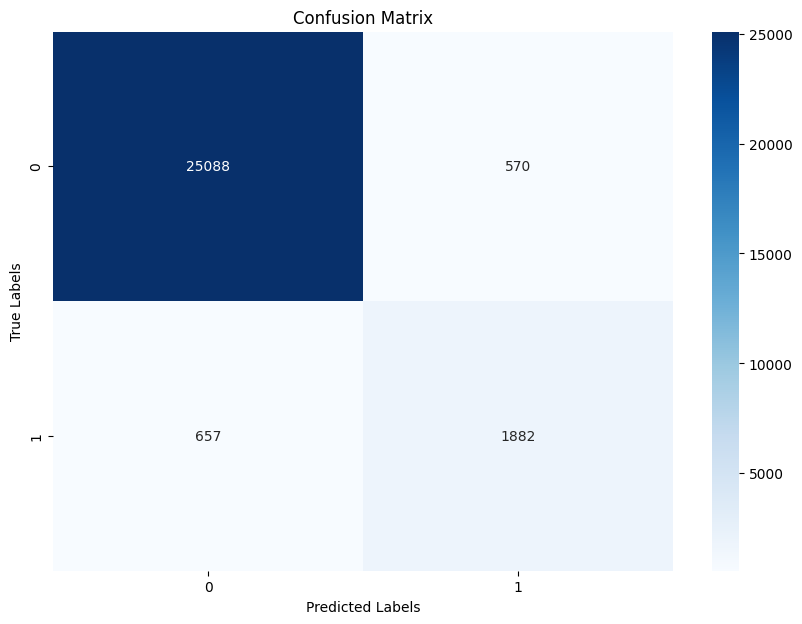

<Figure size 640x480 with 0 Axes>

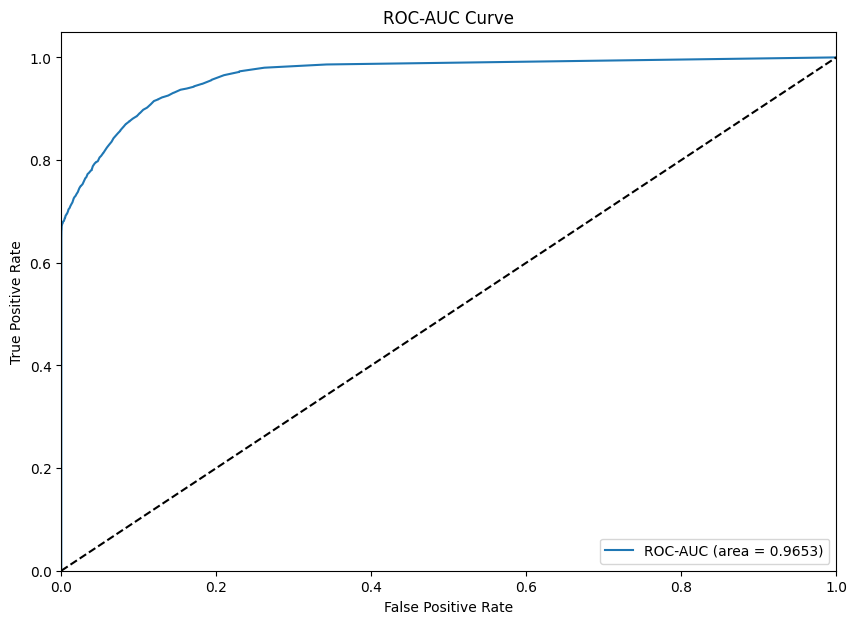

d:\projects\End to End Diabetes Prediction\myenv\lib\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
d:\projects\End to End Diabetes Prediction\myenv\lib\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/28 20:30:44 WARNING mlflow.models.model: Input example should be provided to infer model signature if

++++++++++++++++++++++++++++++++++
AdaBoostClassifier
Accuracy: 0.9326
Precision: 0.9479
Recall: 0.9326
F1 Score: 0.9378

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96     25658
           1       0.59      0.84      0.69      2539

    accuracy                           0.93     28197
   macro avg       0.79      0.89      0.83     28197
weighted avg       0.95      0.93      0.94     28197



<Figure size 640x480 with 0 Axes>

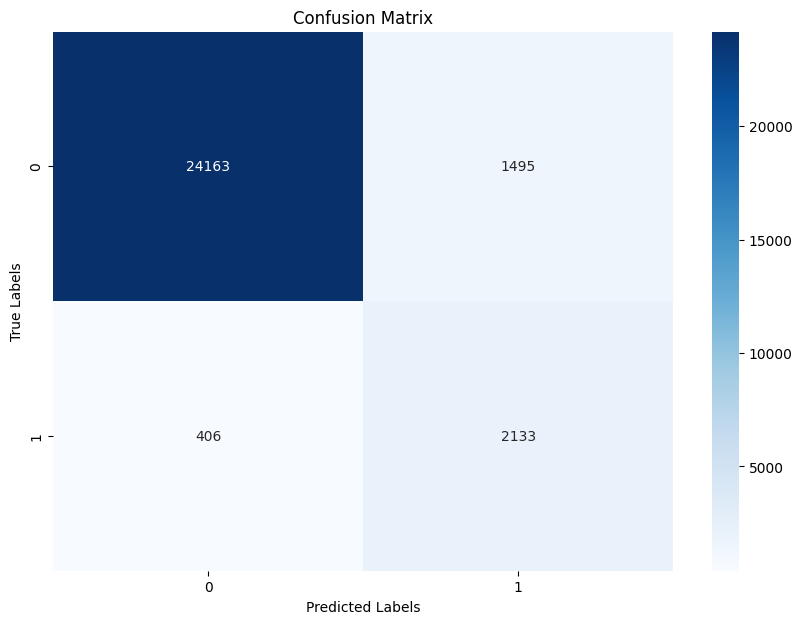

<Figure size 640x480 with 0 Axes>

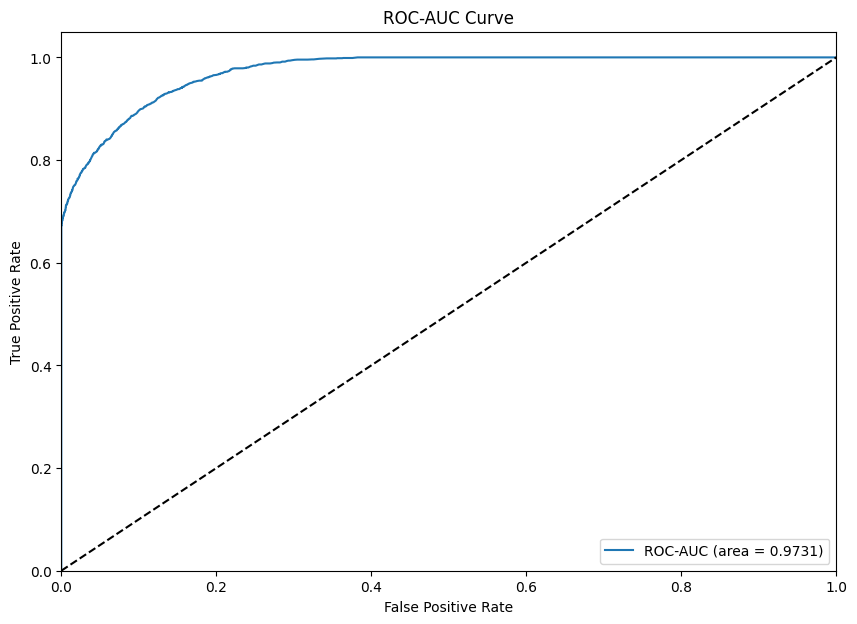

d:\projects\End to End Diabetes Prediction\myenv\lib\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
d:\projects\End to End Diabetes Prediction\myenv\lib\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/28 20:30:56 WARNING mlflow.models.model: Input example should be provided to infer model signature if

++++++++++++++++++++++++++++++++++
XGBClassifier
Accuracy: 0.9677
Precision: 0.9665
Recall: 0.9677
F1 Score: 0.9659

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     25658
           1       0.91      0.71      0.80      2539

    accuracy                           0.97     28197
   macro avg       0.94      0.85      0.89     28197
weighted avg       0.97      0.97      0.97     28197



<Figure size 640x480 with 0 Axes>

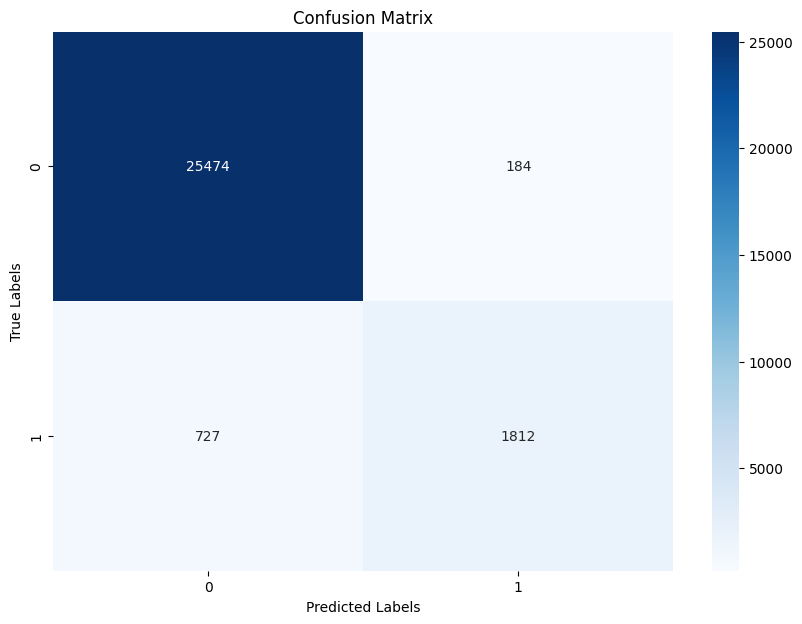

<Figure size 640x480 with 0 Axes>

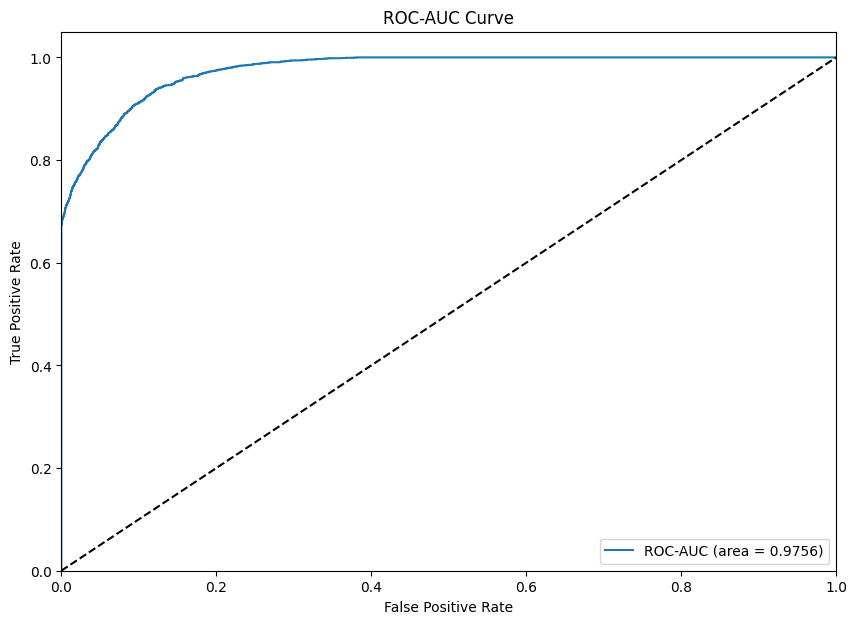

d:\projects\End to End Diabetes Prediction\myenv\lib\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
d:\projects\End to End Diabetes Prediction\myenv\lib\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/28 20:31:05 WARNING mlflow.models.model: Input example should be provided to infer model signature if

++++++++++++++++++++++++++++++++++
KNeighborsClassifier
Accuracy: 0.9069
Precision: 0.9357
Recall: 0.9069
F1 Score: 0.9168

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95     25658
           1       0.49      0.81      0.61      2539

    accuracy                           0.91     28197
   macro avg       0.73      0.86      0.78     28197
weighted avg       0.94      0.91      0.92     28197



<Figure size 640x480 with 0 Axes>

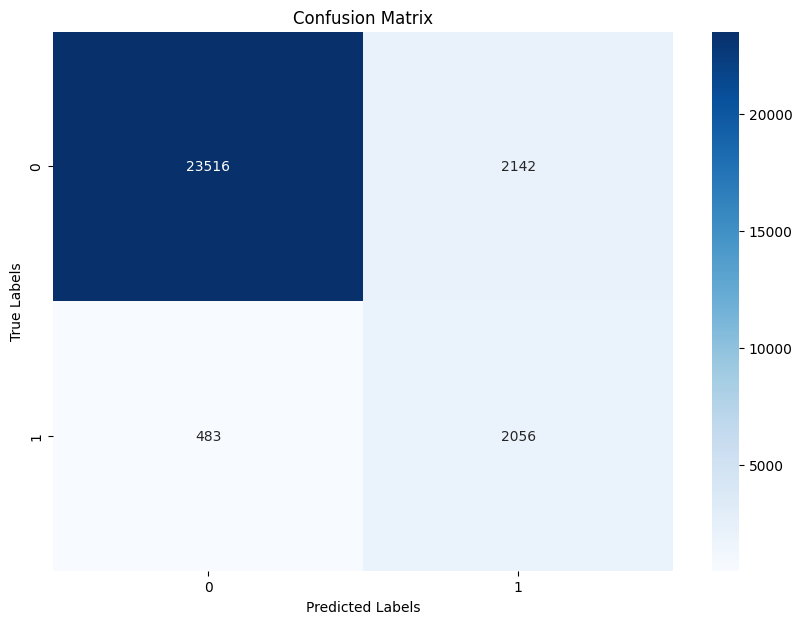

<Figure size 640x480 with 0 Axes>

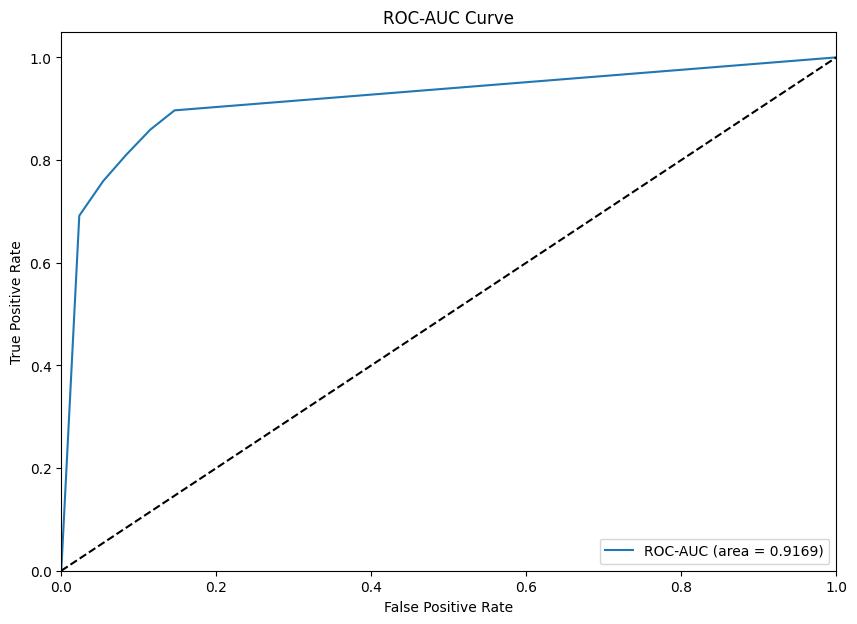

d:\projects\End to End Diabetes Prediction\myenv\lib\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
d:\projects\End to End Diabetes Prediction\myenv\lib\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/28 20:31:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if

++++++++++++++++++++++++++++++++++
SVC
Accuracy: 0.8823
Precision: 0.9404
Recall: 0.8823
F1 Score: 0.9002

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.88      0.93     25658
           1       0.43      0.92      0.58      2539

    accuracy                           0.88     28197
   macro avg       0.71      0.90      0.76     28197
weighted avg       0.94      0.88      0.90     28197



<Figure size 640x480 with 0 Axes>

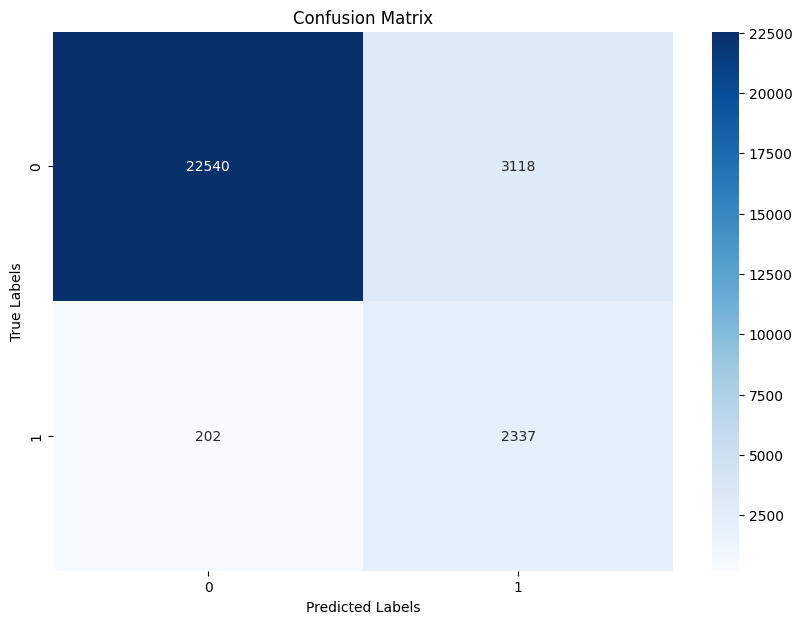

ROC-AUC Curve cannot be displayed because predict_proba is not available for this model.


d:\projects\End to End Diabetes Prediction\myenv\lib\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
d:\projects\End to End Diabetes Prediction\myenv\lib\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/28 20:36:20 WARNING mlflow.models.model: Input example should be provided to infer model signature if

++++++++++++++++++++++++++++++++++
DecisionTreeClassifier
Accuracy: 0.9444
Precision: 0.9483
Recall: 0.9444
F1 Score: 0.9460

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97     25658
           1       0.67      0.76      0.71      2539

    accuracy                           0.94     28197
   macro avg       0.82      0.86      0.84     28197
weighted avg       0.95      0.94      0.95     28197



<Figure size 640x480 with 0 Axes>

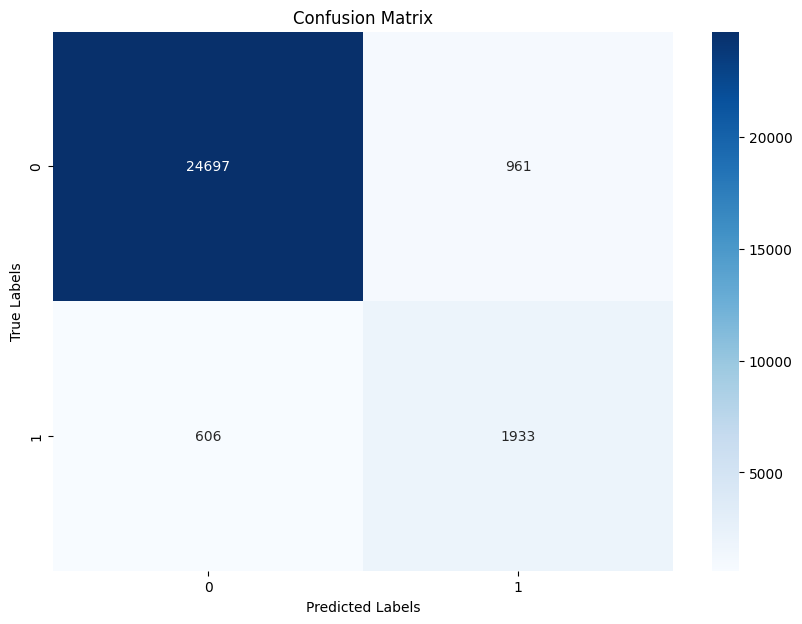

<Figure size 640x480 with 0 Axes>

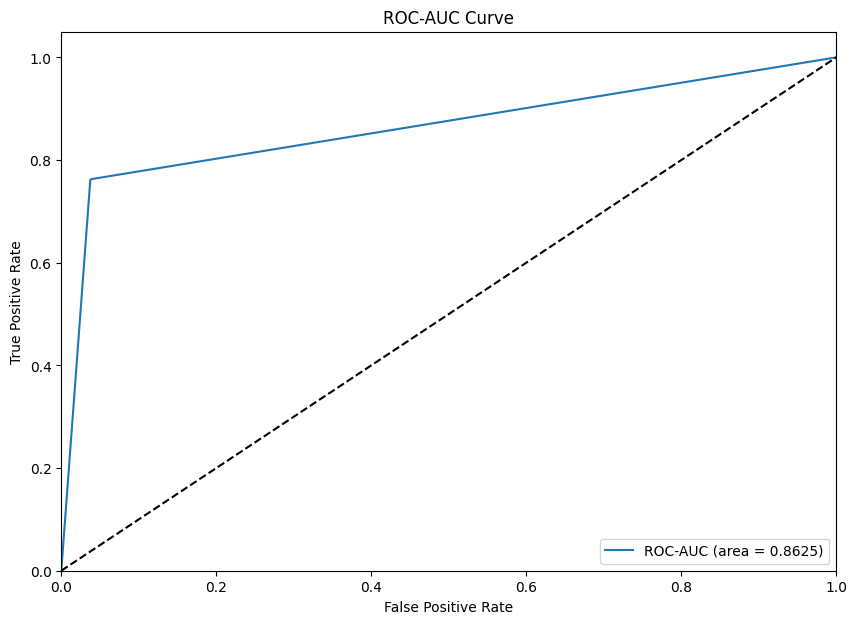

d:\projects\End to End Diabetes Prediction\myenv\lib\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
d:\projects\End to End Diabetes Prediction\myenv\lib\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/28 20:36:25 WARNING mlflow.models.model: Input example should be provided to infer model signature if

++++++++++++++++++++++++++++++++++
LogisticRegression
Accuracy: 0.8867
Precision: 0.9363
Recall: 0.8867
F1 Score: 0.9026

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.89      0.93     25658
           1       0.44      0.87      0.58      2539

    accuracy                           0.89     28197
   macro avg       0.71      0.88      0.76     28197
weighted avg       0.94      0.89      0.90     28197



<Figure size 640x480 with 0 Axes>

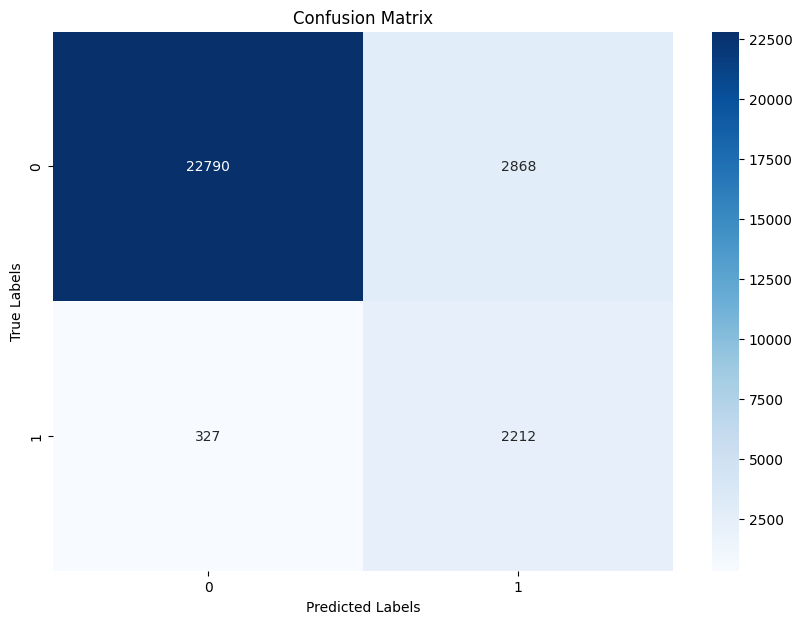

<Figure size 640x480 with 0 Axes>

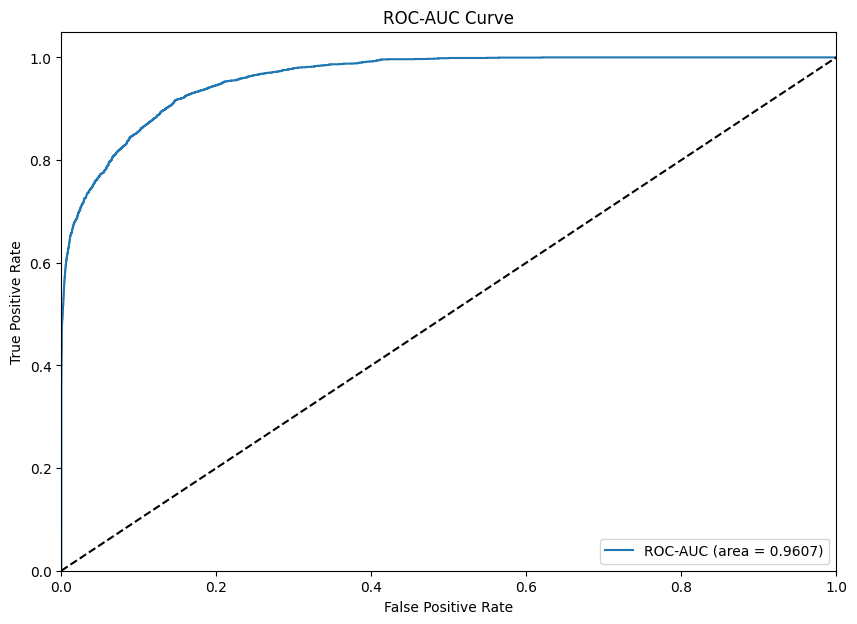

d:\projects\End to End Diabetes Prediction\myenv\lib\site-packages\_distutils_hack\__init__.py:17: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
d:\projects\End to End Diabetes Prediction\myenv\lib\site-packages\_distutils_hack\__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
2024/08/28 20:36:29 WARNING mlflow.models.model: Input example should be provided to infer model signature if

<Figure size 640x480 with 0 Axes>

In [25]:
for model in models:
    evaluate_model(model, X_train, y_train, X_test, y_test)

# Hyperparameter Tuning

XGB classifer had the best performance among all the models. We will now perform hyperparameter tuning for XGBclassifer to improve the overall scores


In [26]:
from scipy.stats import uniform, randint


In [27]:
# Define the model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Define the parameter distribution
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model,
                                   param_distributions=param_dist,
                                   n_iter=20,  # Number of parameter settings that are sampled
                                   scoring='accuracy',
                                   cv=5,  # 5-fold cross-validation
                                   verbose=1,
                                   n_jobs=-1,
                                   random_state=42)

# Fit the random search
random_search.fit(X_train, y_train)

# Get the best parameters and best score
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation accuracy: {:.4f}".format(random_search.best_score_))

# Evaluate the best model on the test set
best_model = random_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test accuracy: {:.4f}".format(test_accuracy))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


d:\projects\End to End Diabetes Prediction\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [21:58:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
2024/08/28 21:58:45 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during xgboost autologging: API request to http://127.0.0.1:5000/api/2.0/mlflow/runs/create failed with exception HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /api/2.0/mlflow/runs/create (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000015086D81B50>: Failed to establish a new connection: [WinError 10061] No connection could be made because the target machine actively refused it'))


Best parameters found:  {'colsample_bytree': 0.9886848381556415, 'gamma': 0.42445691213304193, 'learning_rate': 0.22651885634946198, 'max_depth': 9, 'n_estimators': 191, 'reg_alpha': 0.49379559636439074, 'reg_lambda': 0.5227328293819941, 'subsample': 0.7710164073434198}
Best cross-validation accuracy: 0.9748
Test accuracy: 0.9641


In [28]:
def evaluate_model_trained(model, X_train, y_train, X_test, y_test):

    # Predict on the test set
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("++++++++++++++++++++++++++++++++++")
    print(model.__class__.__name__)
    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Print classification report
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix Heatmap
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # ROC-AUC Curve
    if y_pred_prob is not None:
        if len(y_test.shape) == 1:  # Binary classification
            lb = LabelBinarizer()
            y_test_binarized = lb.fit_transform(y_test)
            roc_auc = roc_auc_score(y_test_binarized, y_pred_prob)
            print("Roc Score", roc_auc)
            fpr, tpr, _ = roc_curve(y_test_binarized, y_pred_prob)
            plt.figure(figsize=(10, 7))
            plt.plot(fpr, tpr, label=f"ROC-AUC (area = {roc_auc:.4f})")
        else:  # Multiclass classification
            y_test_binarized = LabelBinarizer().fit_transform(y_test)
            for i in range(y_test_binarized.shape[1]):
                fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_prob[:, i])
                plt.plot(fpr, tpr, label=f"Class {i} (area = {auc(fpr, tpr):.4f})")

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.title('ROC-AUC Curve')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc='lower right')
        plt.show()
    else:
        print("ROC-AUC Curve cannot be displayed because predict_proba is not available for this model.")


++++++++++++++++++++++++++++++++++
XGBClassifier
Accuracy: 0.9641
Precision: 0.9624
Recall: 0.9641
F1 Score: 0.9625

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     25658
           1       0.86      0.71      0.78      2539

    accuracy                           0.96     28197
   macro avg       0.92      0.85      0.88     28197
weighted avg       0.96      0.96      0.96     28197



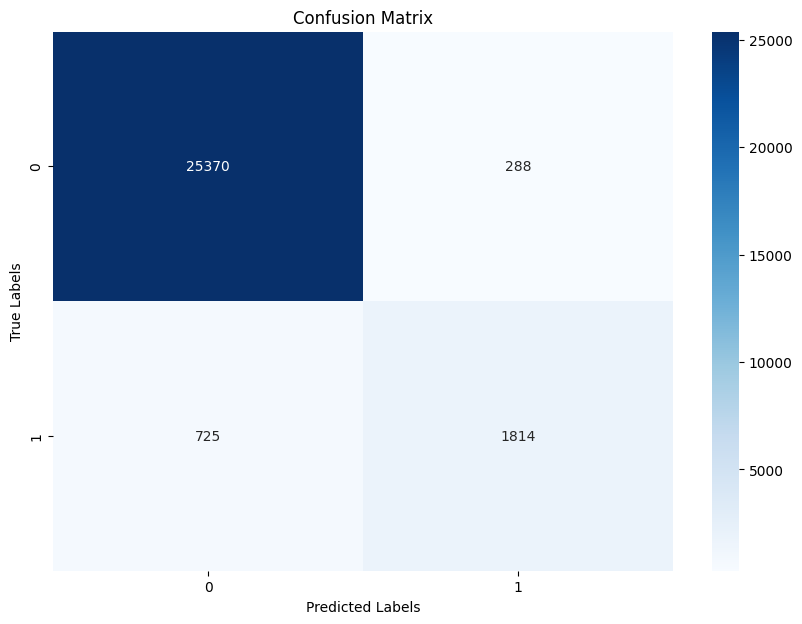

Roc Score 0.9723750677366668


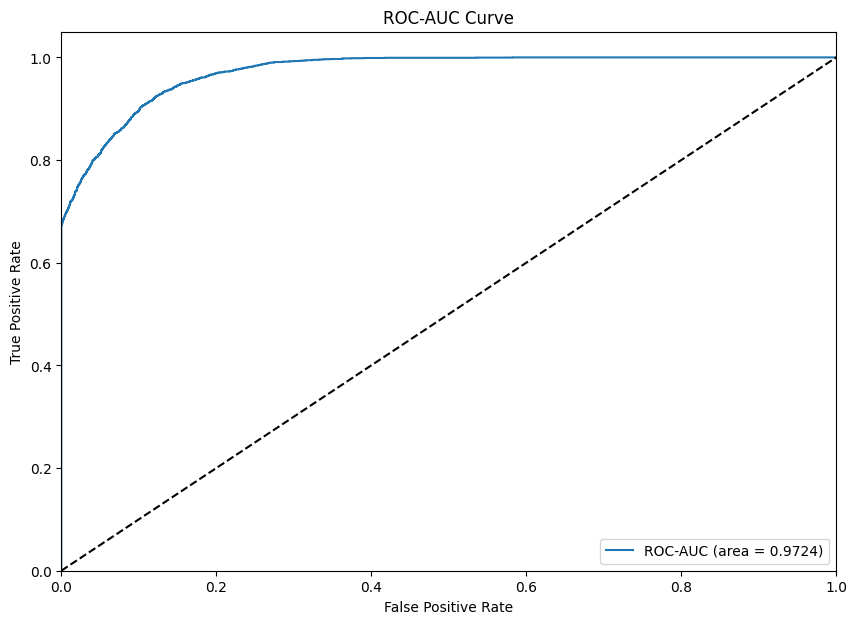

In [29]:
evaluate_model_trained(best_model, X_train, y_train, X_test, y_test)